# Transit Optimization Recovery Integrated into `lightkurve`

I'm going to do this using `batman`, but I hope it doesn't get screwed up because I'm not using `ktransit`. It should be fine but you never know

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
from lightkurve.lightcurve import SyntheticLightCurve
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.injection import TransitModel
import lightkurve.injection as inj
import scipy.optimize as op
import batman

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
tpf_star = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
lc_star = tpf_star.to_lightcurve(aperture_mask='all')

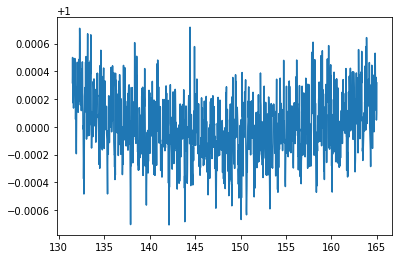

In [3]:
#Remove nans and outliers
lc_star = lc_star.remove_nans().remove_outliers()

lc_star = lc_star.normalize()
plt.plot(lc_star.time, lc_star.flux)

In [4]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 133                      #time of inferior conjunction
params.per = 5.                       #orbital period
params.rp = 0.15                     #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 90.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = lc_star.time.astype(np.float)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  

Just the model:

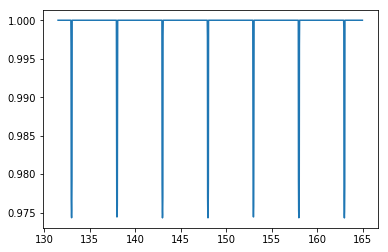

In [5]:
plt.plot(t, flux)

In [7]:
lcinj_time = lc_star.time
lcinj_flux = lc_star.flux * flux
lcinj_fluxerr = lc_star.flux_err

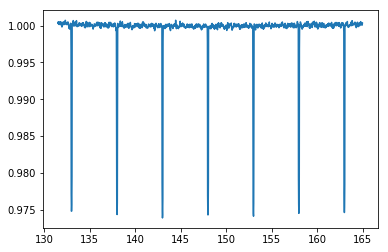

In [8]:
plt.plot(lcinj_time, lcinj_flux)

I'm going to make this a SyntheticLightCurve object, so we can pass it into the `.recover` method.

In [13]:
lcinj = SyntheticLightCurve(time=lcinj_time, flux=lcinj_flux, flux_err=lcinj_fluxerr)

In [31]:
period_f, rprs_f, T0_f = inj.recover(lcinj, 'Planet', x0=[1, 2, 3])

In [32]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = T0_f                   #time of inferior conjunction
params.per = period_f                      #orbital period
params.rp = rprs_f                    #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 90.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = lc_star.time.astype(np.float)  #times at which to calculate light curve
m_fit = batman.TransitModel(params, t, fac=1.0)    #initializes model
flux_fit = m.light_curve(params)

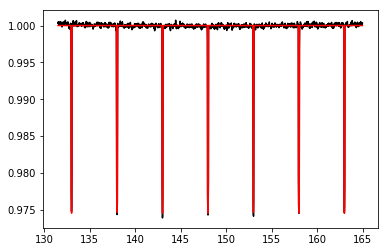

In [33]:
plt.plot(lcinj_time, lcinj_flux, color='k')
plt.plot(t, flux_fit, color='r')